Chapter 2
======
`Conteúudo originamente criado por Cam Davidson-Pilon`

`Transferido para Python 3 e PyMC3 por Max Margenot (@clean_utensils) e Thomas Wiecki (@twiecki) em Quantopian (@quantopian)`

___

Este capítulo apresenta um pouco mais sobre a sintaxe e variáveis PyMC3 e também maneiras de pensar sobre como modelar um sistema a partir de uma perspectiva bayesiana. Ele também contém dicas e técnicas de visualização de dados para avaliar a adequação do seu modelo bayesiano.

----


Versão pt_BR

Tradução por Rodolpho Macedo dos Santos disponibilizado em [Probabilistic-Programming-and-Bayesian-Methods-for-Hackers](http://github.com/rodolphomacedo/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

## Um pouco mais do PyMC3

### Contexto do Modelo

No PyMC3, normalmente lidamos com todas as variáveis que queremos em nosso modelo dentro do contexto do objeto `Model`.

In [1]:
import pymc3 as pm

with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0)
    data_generator = pm.Poisson("data_generator", parameter)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Esta é uma camada extra de conveniência em comparação com o PyMC. Quaisquer variáveis criadas dentro de um determinado contexto de `Model` serão automaticamente atribuídas a esse modelo. Se você tentar definir uma variável fora do contexto de um modelo, receberá um erro.

Podemos continuar a trabalhar dentro do contexto do mesmo modelo usando `with` com o nome do objeto de modelo que já criamos.

In [2]:
with model:
    data_plus_one = data_generator + 1

Podemos examinar as mesmas variáveis fora do contexto do modelo uma vez que tenham sido definidas, mas para definir mais variáveis que o modelo reconhecerá, elas devem estar dentro do contexto.

In [3]:
parameter.tag.test_value

array(0.69314718)

Cada variável atribuída a um modelo será definida com seu próprio nome, o primeiro parâmetro é uma string (abordaremos isso mais adiante na seção de variáveis). Para criar um  objeto *model* diferente com o mesmo nome de um que usamos anteriormente, precisamos apenas executar o primeiro bloco de código novamente.

In [4]:
with pm.Model() as model:
    theta = pm.Exponential("theta", 2.0)
    data_generator = pm.Poisson("data_generator", theta)

Também podemos definir um modelo totalmente separado. Observe que somos livres para nomear nossos modelos como quisermos, portanto, se não quisermos sobrescrever um modelo antigo, precisamos apenas fazer outro.

In [5]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform("P(A)", 0, 1)
    p_B = pm.Uniform("P(B)", 0, 1)

You probably noticed that PyMC3 will often give you notifications about transformations when you add variables to your model. These transformations are done internally by PyMC3 to modify the space that the variable is sampled in (when we get to actually sampling the model). This is an internal feature which helps with the convergence of our samples to the posterior distribution and serves to improve the results.

###  Váriaveis no PyMC3

Todas as variáveis PyMC3 têm um valor inicial (ou seja, `test_value`). Usando as mesmas variáveis de antes:

In [6]:
print("parameter.tag.test_value =", parameter.tag.test_value)
print("data_generator.tag.test_value =", data_generator.tag.test_value)
print("data_plus_one.tag.test_value =", data_plus_one.tag.test_value)

parameter.tag.test_value = 0.6931471824645996
data_generator.tag.test_value = 0
data_plus_one.tag.test_value = 1


O `test_value` é usado apenas no contexto interno do modelo, como o ponto de partida para a amostragem se nenhum outro início for especificado. Não mudará como resultado da amostragem. Este estado inicial pode ser alterado na criação da variável especificando um valor para o parâmetro `testval`.

In [7]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, testval=0.5)

print("\nparameter.tag.test_value =", parameter.tag.test_value)


parameter.tag.test_value = 0.5


Isso pode ser útil se você estiver usando uma priori mais instável que pode exigir um ponto de partida melhor.

PyMC3 está interessado em dois tipos de variáveis de programação: estocásticas e determinísticas.

* *variáveis estocásticas* são variáveis que não são determinísticas, ou seja, mesmo que você conhecesse todos os valores dos parâmetros e componentes das variáveis, ainda seria aleatório. Incluídas nesta categoria estão as instâncias das classes `Poisson`,` DiscreteUniform` e `Exponencial`.

* *variáveis determinísticas* são variáveis que não são aleatórias se os parâmetros e componentes das variáveis forem conhecidos. Isso pode ser confuso no início: uma verificação mental rápida é *se eu soubesse todas as variáveis de componente da variável `foo`, poderia determinar qual é o valor de` foo`.*

#### Inicializando as variáveis estocásticas 

Inicializar uma variável estocástica (ou aleatória) requer um argumento `name`, além de parâmetros adicionais que são específicos da classe. Por exemplo:

`alguma_variável = pm.DiscreteUniform ("discrete_uni_var", 0, 4)`

onde 0, 4 são os limites inferior e superior específicos de `DiscreteUniform` na variável aleatória. Os [documentos PyMC3] (http://pymc-devs.github.io/pymc3/api.html) contêm os parâmetros específicos para variáveis estocásticas. (Ou use `??` se estiver usando IPython!)

O atributo `name` é usado para recuperar a distribuição à posteriori após obter os resultados da análise, então é melhor usar um nome descritivo. Normalmente, eu uso o nome da variável Python como o `name`.

Para problemas multivariáveis, em vez de criar uma matriz Python de variáveis estocásticas, endereçar a palavra-chave `shape` na chamada para uma variável estocástica cria uma matriz multivariada de variáveis estocásticas (independentes). O array se comporta como um array NumPy quando usado como um, e as referências ao seu atributo `tag.test_value` retornam arrays NumPy.

O argumento `shape` também resolve o irritante caso em que você pode ter muitas variáveis $\beta_i, \; i = 1, ..., N$ que você deseja modelar. Em vez de criar nomes e variáveis arbitrários para cada um, como:

    beta_1 = pm.Uniform("beta_1", 0, 1)
    beta_2 = pm.Uniform("beta_2", 0, 1)
    ...

podemos, em vez disso, agrupá-los em uma única variável:

    betas = pm.Uniform("betas", 0, 1, shape=N)

#### Variáveis determinísticas

Podemos criar uma variável determinística de uma forma semelhante a como criamos uma variável estocástica. Simplesmente chamamos a classe `Deterministic` em PyMC3 e passamos a função que desejamos

     variavel_deterministica = pm.Deterministic("deterministic_variable", alguma_função_de_variáveis)

Para todos os efeitos, podemos tratar o objeto `variavel_deterministica` como uma variável e não uma função Python.

Chamar `pymc3.Deterministic` é a maneira mais óbvia, mas não a única, de criar variáveis determinísticas. Operações elementares, como adição, exponenciais etc. criam implicitamente variáveis determinísticas. Por exemplo, o seguinte retorna uma variável determinística:

In [8]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

Se quisermos que uma variável `deterministic` realmente seja rastreada por nossa amostragem, no entanto, precisamos defini-la explicitamente como uma variável denominada` deterministic` no construtor.

O uso da variável `deterministic` foi visto no exemplo de mensagem de texto do capítulo anterior. Lembre-se de que o modelo para $\lambda$ parecia:

$$
\lambda = 
\begin{cases}\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

E no código PyMC3:

In [9]:
import numpy as np

n_data_points = 5  # in CH1 we had ~70 data points
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

Claramente, se $\tau, \lambda_1 \mbox{ e } \lambda_2$ são conhecidos, então $\lambda$ é conhecido completamente, portanto, é uma variável determinística. Usamos a função `switch` aqui para mudar de $\lambda_1$ para $\lambda_2$ no momento apropriado. Esta função vem diretamente do pacote `theano`, que discutiremos na próxima seção.

Dentro de uma variável `deterministic`, as variáveis estocásticas passadas se comportam como escalares ou matrizes NumPy (se multivariável). Podemos fazer o que quisermos com eles, desde que as dimensões correspondam aos nossos cálculos.

Por exemplo, executando o seguinte:

    def subtract(x, y):
        return x - y
    
    stochastic_1 = pm.Uniform("U_1", 0, 1)
    stochastic_2 = pm.Uniform("U_2", 0, 1)
    
    det_1 = pm.Deterministic("Delta", subtract(stochastic_1, stochastic_2))
    
É um código PyMC3 perfeitamente válido. Dizer que nossas expressões se comportam como matrizes NumPy não é exatamente honesto aqui, no entanto. O principal problema é que a expressão que estamos criando *deve* ser compatível com os tensores `theano`, que abordaremos na próxima seção. Sinta-se à vontade para definir as funções de que você precisa para compor seu modelo. No entanto, se você precisar fazer cálculos semelhantes a matrizes que requerem funções NumPy, certifique-se de usar seus equivalentes em `theano`.

### Theano

A maior parte do trabalho pesado feito pelo PyMC3 é feito com o pacote `theano`. A notação em `theano` é notavelmente semelhante ao NumPy. Ele também suporta muitos dos elementos computacionais familiares do NumPy. No entanto, enquanto o NumPy executa cálculos diretamente, por exemplo, quando você executa `a + b`,` theano` em vez disso constrói um "grafo computacional" que rastreia que você deseja realizar a operação `+` nos elementos `a` e` b`. Apenas quando você executa a expressão `eval ()` no `theano` o cálculo ocorre (ou seja, `theano` é calculado preguiçosamente $^1$). Uma vez que o grafo computacional é construído, podemos realizar todos os tipos de otimizações matemáticas (por exemplo, simplificações), computar gradientes via autodiff, compilar o gráfico inteiro em C para rodar na velocidade da máquina e também compilá-lo para rodar na GPU. PyMC3 é basicamente uma coleção de expressões simbólicas `theano` para várias distribuições de probabilidade que são combinadas em um grande grafo computacional que compõe todo o log de probabilidade do modelo e uma coleção de algoritmos de inferência que usam esse gráfico para calcular probabilidades e gradientes. Para fins práticos, isso significa que, para construir certos modelos, às vezes temos que usar `theano`.

Vamos escrever algum código PyMC3 que envolva cálculos `theano`.

----
$^1$ Nota do Tradutor: calculado preguiçosamente, em inglês é chamado de *lazy evaluated*. Como dito acima, o termo *lazy* indicada que os cáculos serão realizados apenas quando for pedido que rode ou quando for preciso.


In [10]:
import theano.tensor as tt

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

Aqui usamos a função `stack()` do `theano` da mesma forma que usaríamos uma das funções de empilhamento de NumPy: para combinar nossas duas variáveis separadas, `p1` e` p2`, em um vetor com $2$ elementos. A variável estocástica `categorical` não entende o que queremos dizer se passarmos um array NumPy de`p1` e `p2` para ela, porque ambas são variáveis `theano`. Empilhá-los assim nós os combinamos em apenas uma variável `theano`, que assim, podemos usar como o par complementar de probabilidades para nossas duas categorias.

Ao longo deste livro, usamos várias funções `theano` para ajudar a construir nossos modelos. Se você tiver mais interesse em olhar o próprio `theano`, certifique-se de verificar a [documentação](http://deeplearning.net/software/theano/library/).

Após essas considerações técnicas, podemos voltar a definir nosso modelo!

### Incluindo observações no modelo

Neste ponto, pode não parecer, mas nós especificamos totalmente nossas prioris. Por exemplo, podemos fazer e responder perguntas  tais como: "Qual é a aparência da minha distribuição à priori de $\lambda_1$?"

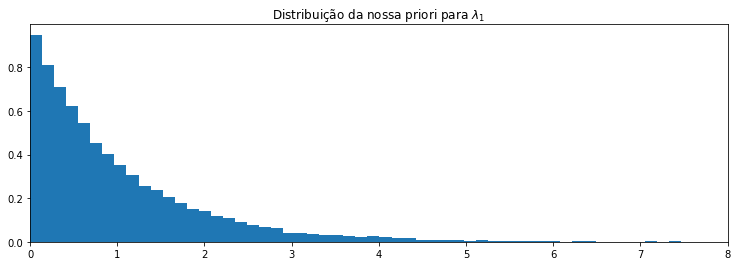

In [11]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
figsize(12.5, 4)


samples = lambda_1.random(size=20000)
plt.hist(samples, bins=70, density=True, histtype="stepfilled")
plt.title("Distribuição da nossa priori para $\lambda_1$")
plt.xlim(0, 8);

Para enquadrar isso na notação do primeiro capítulo, embora isso seja um leve abuso de notação, especificamos $P(A)$. Nosso próximo objetivo é incluir dados/evidências/observações de $X$ em nosso modelo.

Variáveis estocásticas PyMC3 têm um argumento nomeado com palavra-chave `observed`. A palavra-chave `observed` tem um papel muito simples: fixar o valor atual da variável a ser os dados fornecidos, tipicamente em um NumPy `array` ou pandas `DataFrame`. Por exemplo:

In [12]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson("fxd", 1, observed=data)
print("value: ", fixed_variable.tag.test_value)

value:  [10  5]


É assim que incluímos dados em nossos modelos: inicializando uma variável estocástica para ter um *valor fixo*.

Para completar nosso exemplo de mensagem de texto, fixamos a variável PyMC3 `observations` no conjunto de dados observado.

In [13]:
# Estamos usando alguns dados falsos aqui
data = np.array([10, 25, 15, 20, 35])

with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]


## Abordagens de modelagem

Uma boa ideia inicial para a modelagem bayesiana é pensar sobre *como seus dados podem ter sido gerados*. Posicione-se em uma posição onisciente e tente imaginar como *você* recriaria o conjunto de dados.

No último capítulo, investigamos os dados das mensagens de texto. Começamos perguntando como nossas observações podem ter sido geradas:

1. Começamos pensando "qual é a melhor variável aleatória para descrever esses dados de contagem?" Uma variável aleatória de Poisson é um bom candidato porque pode representar dados de contagem. Portanto, modelamos o número de sms recebidos como amostra de uma distribuição de Poisson.

2. Em seguida, pensamos, "Ok, assumindo que os sms são distribuídos conforme uma Poisson, o que eu preciso para a distribuição de Poisson?" Bem, a distribuição de Poisson tem um parâmetro $\lambda$.

3. Nós conhecemos $\lambda$? Não. Na verdade, suspeitamos que existam *dois* valores $\lambda $, um para o comportamento anterior e outro para o comportamento posterior. Não sabemos quando o comportamento muda, mas chame o ponto de troca (em inglês, switchpoint) $\tau$.

4. Qual é uma boa distribuição para os dois $\lambda$s? O exponencial é bom, pois atribui probabilidades a números reais positivos. Bem, a distribuição exponencial também tem um parâmetro, chame-o de $\alpha$.

5. Sabemos qual pode ser o parâmetro $\alpha$? Não. Neste ponto, poderíamos continuar e atribuir uma distribuição a $\alpha$, mas é melhor parar quando atingirmos um determinado nível de ignorância: embora tenhamos uma crença à priori sobre $\lambda$, ("$\lambda$ provavelmente mudará ao longo do tempo", "$\lambda$ provavelmente está entre 10 e 30", etc.), não temos realmente nenhuma crença forte sobre $\alpha$. Portanto, é melhor parar por aqui.

    Qual é então um bom valor para $\alpha$? Achamos que $\lambda$s estão entre 10-30, portanto, se definirmos $\alpha$ realmente baixo (o que corresponde a maior probabilidade em valores altos), não estamos refletindo bem a nossa priori. Similarmente, um alfa muito alto também ignora nossa crença à priori. Uma boa ideia para $\alpha$ refletir a nossa crença é definir o valor de forma que a média de $\lambda$, dado $\alpha$, seja igual à nossa média observada. Isso foi mostrado no último capítulo.

6. Não temos opinião especializada sobre quando $\tau$ pode ter ocorrido. Portanto, suporemos que $\tau$ é de uma distribuição uniforme discreta ao longo de todo o intervalo de tempo.



Abaixo, damos uma visualização gráfica disso, onde as setas denotam relacionamentos `pai-filho`. (fornecido pela [biblioteca Daft Python](http://daft-pgm.org/))

<img src = "http://i.imgur.com/7J30oCG.png" width = 700 />


PyMC3, e outras linguagens de programação probabilísticas, foram projetadas para contar essas *histórias* de geração de dados. De maneira mais geral, B. Cronin escreve[5]:

> A programação probabilística desbloqueará explicações narrativas de dados, um dos santos graais da análise de negócios e o herói anônimo da persuasão científica. As pessoas pensam em termos de histórias - daí o poder irracional da anedota para conduzir a tomada de decisão, bem fundamentada ou não. Mas a análise existente falha amplamente em fornecer esse tipo de história; em vez disso, os números parecem surgir do nada, com pouco do contexto causal que os humanos preferem ao pesar suas opções.

### Mesma história; final diferente.

Curiosamente, podemos criar *novos conjuntos de dados* recontando a história.
Por exemplo, se invertermos as etapas acima, podemos simular uma possível realização do conjunto de dados.

1\. Especifique quando o comportamento do usuário muda por amostragem de $\text {DiscreteUniform} (0, 80)$:

In [14]:
tau = np.random.randint(0, 80)
print(tau)

45


2\. Sortear $\lambda_1$ e $\lambda_2$ a partir da distribuição $\text{Exp}(\alpha)$:

In [15]:
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

8.932162583028077 6.402995942782646


3\. Para dias anteriores à $\tau$, representam a contagem de SMS recebidos do usuário por amostragem a partir de $\text{Poi} (\lambda_1)$, e amostra de $\text{Poi} (\lambda_2)$ para dias após $\tau$ . Por exemplo: sorteie um número aleatório A e B

In [16]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

4\. Desenhar o conjunto de dados artificial:

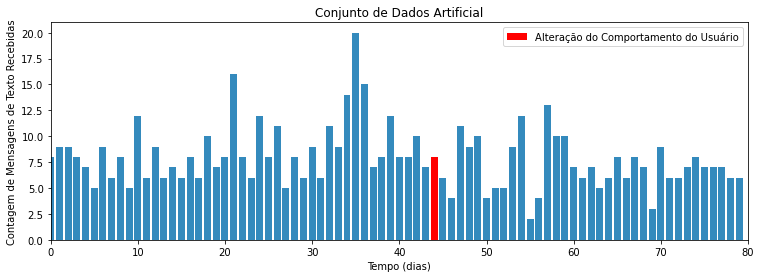

In [17]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label="Alteração do Comportamento do Usuário")
plt.xlabel("Tempo (dias)")
plt.ylabel("Contagem de Mensagens de Texto Recebidas")
plt.title("Conjunto de Dados Artificial")
plt.xlim(0, 80)
plt.legend();

Sabemos que nosso conjunto de dados fictício não se parece com o nosso conjunto de dados observado: a probabilidade é incrivelmente pequena, de fato seria! O motor do PyMC3 é projetado para encontrar bons parâmetros, $\lambda_i, \tau$, que maximizam essa probabilidade.

A capacidade de gerar conjuntos de dados artificiais é um efeito colateral interessante de nossa modelagem, e veremos que essa capacidade é um método muito importante de inferência bayesiana. Produzimos mais alguns conjuntos de dados abaixo:

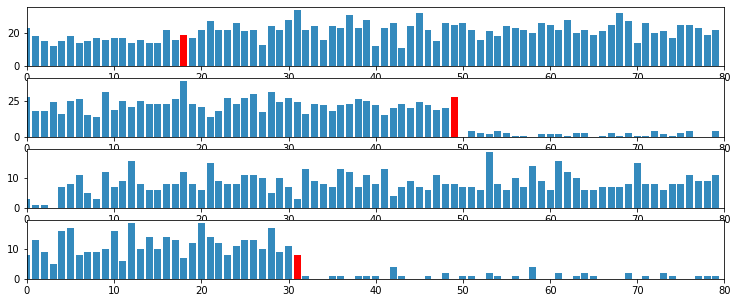

In [18]:
def plot_artificial_sms_dataset():
    tau = stats.randint.rvs(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=1/alpha, size=2)
    data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
    plt.bar(np.arange(80), data, color="#348ABD")
    plt.bar(tau - 1, data[tau-1], color="r", label="Alteração do Comportamento do Usuário")
    plt.xlim(0, 80);

figsize(12.5, 5)
plt.title("Mais exemplo com conjunto de dados Artificial")
for i in range(4):
    plt.subplot(4, 1, i+1)
    plot_artificial_sms_dataset()


Mais tarde, veremos como usamos isso para fazer previsões e testar a adequação de nossos modelos.

##### Exemplo: teste A / B Bayesiano

O teste A/B é um padrão de projeto estatístico para determinar a diferença de efetiva entre dois tratamentos diferentes. Por exemplo, uma empresa farmacêutica está interessada na eficácia do medicamento A em relação ao medicamento B. A empresa testará o medicamento A em alguma fração de seus ensaios e o medicamento B na outra fração (esta fração costuma ser 1/2, mas iremos relaxar$^1$ essa suposição). Depois de realizar testes suficientes, os estatísticos internos analisam os dados para determinar qual medicamento produziu melhores resultados.

Da mesma forma, os desenvolvedores web front-end estão interessados em saber qual design de seu site gera mais vendas ou alguma outra métrica de interesse. Eles direcionarão uma parte dos visitantes para o site A e a outra fração para o site B, e registrarão se a visita rendeu uma venda ou não. Os dados são registrados (em tempo real) e analisados posteriormente.

Frequentemente, a análise pós-experimento é feita usando algo chamado teste de hipótese como *teste de diferença de médias* ou *teste de diferença de proporções*. Isso envolve quantidades frequentemente mal interpretadas como um "z-score" e ainda mais "valores p" confusos (por favor, não pergunte). Se você fez um curso de estatística, provavelmente aprendeu essa técnica (embora não necessariamente *tenha aprendido* essa técnica). E se você fosse como eu, pode ter se sentido incomodado com a derivação deles - bom: a abordagem bayesiana desse problema é muito mais natural.



### Um caso simples

Como este é um livro de hackers, continuaremos com o exemplo sobre *web-dev*. No momento, vamos nos concentrar na análise do site A apenas. Suponha que haja alguma probabilidade real de $0 \lt p_A \lt 1$ de que os usuários que, no site A, eventualmente comprem do site. Esta é a verdadeira eficácia do site A. Atualmente, essa quantidade é desconhecida para nós.

Suponha que o site A foi mostrado a $N$ pessoas e $n$ pessoas compraram nele. Pode-se concluir apressadamente que $p_A = \frac{n}{N}$. Infelizmente, a *frequência observada* $\frac{n}{N}$ não é necessariamente igual a $p_A$ - há uma diferença entre a *frequência observada* e a *frequência verdadeira* de um evento. A verdadeira frequência pode ser interpretada como a probabilidade de um evento ocorrer. Por exemplo, a verdadeira frequência de lançar um 1 em um dado de 6 lados é $\frac{1}{6}$. Precisamos saber a verdadeira frequência de eventos como:

- fração de usuários que fazem compras,
- frequência de atributos sociais,
- porcentagem de usuários da Internet com gatos etc.

são informações comuns que perguntamos à **Natureza**. Infelizmente, muitas vezes a Natureza nos esconde a verdadeira frequência e, assim, devemos *inferir* a partir dos dados observados.

A *frequência observada* é então a frequência que observamos: digamos, lançando o dado 100 vezes, você poderá observar 20 resultados da face 1. A frequência observada, $0.2$ ($=\frac{20}{100}$), difere da frequência verdadeira, $\frac{1}{6}$. Podemos usar a estatística bayesiana para inferir os valores prováveis da frequência verdadeira usando dados anteriores e observados apropriados.

Com relação ao nosso exemplo A/B, estamos interessados em usar o que sabemos, $N$ (o total de testes administrados) e $n$ (o número de conversões), para estimar qual $p_A$, a verdadeira frequência de compradores, pode ser.

Para configurar um modelo bayesiano, precisamos atribuir distribuições à priori às nossas quantidades desconhecidas. *À priori*, o que achamos que $p_A$ pode ser? Para este exemplo, não temos uma forte convicção sobre $p_A$, então, por enquanto, vamos assumir que $p_A$ é uniforme em [0,1]:

-----

$^1$ **Nota do Tradutor**: Em modelagem estatística o termo *relaxar* significa que essa hipótese não será aplicada ao modelo. Nesse caso, a divisão das partes poderá ser qualquer fracionamento adeaquado.

In [19]:
import pymc3 as pm

# The parameters are the bounds of the Uniform.
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

Se tivéssemos crenças mais fortes, poderíamos tê-las expressado no item anterior.

Para este exemplo, considere $p_A = 0.05$ e $N = 1500$ usuários mostrados no site A, e vamos simular se o usuário fez uma compra ou não. Para simular isso a partir de $N$ tentativas, usaremos uma distribuição *Bernoulli*: se $X \ \sim \text{Ber}(p)$, então $X$ é 1 com probabilidade $p$ e 0 com probabilidade $1 - p$. Claro, na prática não conhecemos $p_A$, mas vamos usá-lo aqui para simular os dados.

In [20]:
#definir constantes
p_true = 0.05  # lembre-se, isso é desconhecido.
N = 1500

# amostra de N variáveis aleatórias de Bernoulli - Ber(0,05). 
# cada variável aleatória tem 0,05 de chance de ser 1
# esta é a etapa de geração de dados
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences) # Lembre-se: Python trata True == 1 e False == 0
print(np.sum(occurrences))

[0 0 0 ... 0 0 0]
64


A frequência observada é:

In [21]:
# Ocorrências. Média é igual n/N.
print("Qual é a frequência observada no Grupo A?\n R: %.4f" % np.mean(occurrences))
print("\nIsso é igual à frequência verdadeira?\n R: %s" % (np.mean(occurrences) == p_true))

Qual é a frequência observada no Grupo A?
 R: 0.0427

Isso é igual à frequência verdadeira?
 R: False


Combinamos as observações na variável PyMC3 `observed` e executamos nosso algoritmo de inferência:

In [22]:
# incluem as observações, que são Bernoulli
with model:
    obs = pm.Bernoulli("obs", p, observed=occurrences)
    # To be explained in chapter 3
    step = pm.Metropolis()
    trace = pm.sample(18000, step=step)
    burned_trace = trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains, 0 divergences: 100%|██████████| 74000/74000 [00:05<00:00, 13761.44draws/s]
The number of effective samples is smaller than 25% for some parameters.


We plot the posterior distribution of the unknown $p_A$ below:

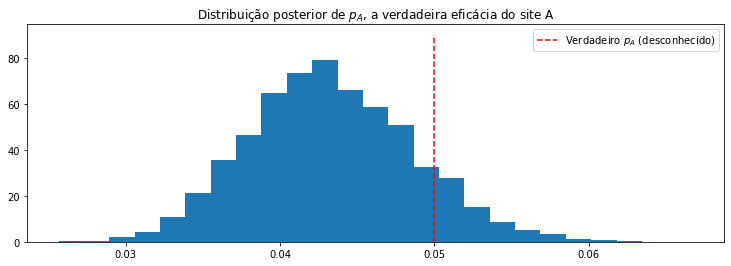

In [23]:
figsize(12.5, 4)
plt.title("Distribuição posterior de $ p_A $, a verdadeira eficácia do site A")
plt.vlines(p_true, 0, 90, linestyle="--", label="Verdadeiro $p_A$ (desconhecido)", color='red')
plt.hist(burned_trace["p"], bins=25, histtype="stepfilled", density=True)
plt.legend();

Nossa distribuição à posteriori coloca a maior parte do peso perto do valor verdadeiro de $p_A$, mas também alguns pesos nas caudas. Esta é uma medida de quão incertos devemos ser, dadas as nossas observações. Tente mudar o número de observações, `N`, e observe como a distribuição posterior muda.

### *A* e *B* Juntos

Uma análise semelhante pode ser feita para os dados de resposta do site B para determinar o análogo $p_B$. Mas o que realmente nos interessa é a *diferença* entre $p_A$ e $p_B$. Vamos inferir $p_A$, $p_B$, *e* $\text{delta} = p_A - p_B$, todos de uma vez. Podemos fazer isso usando as variáveis determinísticas de PyMC3. (Assumiremos para este exercício que $p_B = 0.04$, então $ \text{delta} = 0.01 $, $N_B = 750$ (significativamente menos que $N_A$) e vamos simular os dados do site B como fizemos para dados do site A)

In [24]:
import pymc3 as pm
figsize(12, 4)

# essas duas quantidades são desconhecidas para nós.
true_p_A = 0.05
true_p_B = 0.04

# note os tamanhos de amostra desiguais - nenhum problema na análise bayesiana.
N_A = 1500
N_B = 750

# gerar algumas observações
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs do Site A: ", observations_A[:30], "...")
print("Obs do Site B: ", observations_B[:30], "...")

Obs do Site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0] ...
Obs do Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [25]:
print(np.mean(observations_A))
print(np.mean(observations_B))

0.04733333333333333
0.036


In [26]:
# Configure o modelo pymc3. Mais uma vez, assuma priors uniformes para p_A e p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:12<00:00, 6665.16draws/s] 
The number of effective samples is smaller than 25% for some parameters.


Abaixo, traçamos as distribuições posteriores para as três incógnitas:

In [27]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

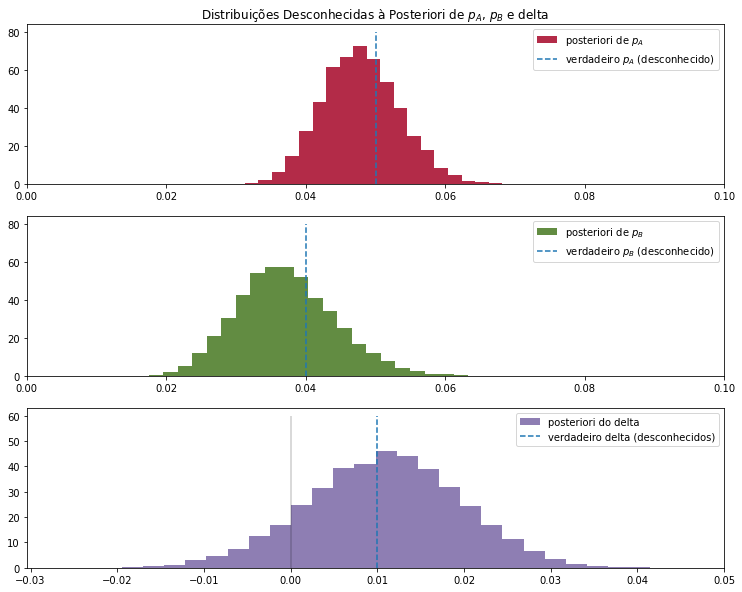

In [28]:
figsize(12.5, 10)

# Histograma das posterioris

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posteriori de $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="verdadeiro $p_A$ (desconhecido)")
plt.legend(loc="upper right")
plt.title("Distribuições Desconhecidas à Posteriori de $p_A$, $p_B$ e delta")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posteriori de $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="verdadeiro $p_B$ (desconhecido)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posteriori do delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="verdadeiro delta (desconhecidos)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

Observe que como resultado de `N_B < N_A`, ou seja, temos menos dados do site B, nossa distribuição à posteriori de $p_B$ é mais gorda, implicando que estamos menos certos sobre o valor verdadeiro de $p_B$ do que de $p_A$.

Com respeito à distribuição à posteriori de $\text {delta}$, podemos ver que a maioria da distribuição está acima de $\text{delta} = 0 $, implicando que a resposta do site A é provavelmente melhor do que a resposta do site B. A probabilidade de que essa inferência esteja incorreta é facilmente computável:

In [29]:
# Conte o número de amostras menor que 0, ou seja, a área sob a curva
# menores que 0, representa a probabilidade de que o site A seja pior do que o site B.

print("Probabilidade de que o site A é PIOR que o site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probabilidade de que o site A é MELHOR do que o site B: %.3f" % \
    np.mean(delta_samples > 0))

Probabilidade de que o site A é PIOR que o site B: 0.115
Probabilidade de que o site A é MELHOR do que o site B: 0.885


Se esta probabilidade for muito alta para uma tomada de decisão mais confortável, então podemos realizar mais testes no site B (como o local B tem menos amostras para começar, cada ponto de dados adicional para o local B contribui com mais "poder" inferencial do que cada ponto de dados adicional para site A).

Tente brincar com os parâmetros `true_p_A`,`true_p_B`, `N_A` e` N_B`, para ver como a posterior de $\text{delta}$ se parece. Observe que, a diferença nos tamanhos das amostras entre o site A e o site B nunca foi mencionada: ela se encaixa naturalmente na análise bayesiana.

Espero que os leitores sintam que esse estilo de teste A/B é mais natural do que o teste de hipóteses, que provavelmente confundiu mais do que ajudou os profissionais. Posteriormente neste livro, veremos duas extensões desse modelo: a primeira para ajudar a ajustar dinamicamente para sites ruins, e a segunda irá melhorar a velocidade desse cálculo, reduzindo a análise a uma única equação.

## Um algoritmo para engano humano

Os dados sociais têm uma camada adicional de interesse, já que as pessoas nem sempre são honestas com as respostas, o que complica ainda mais a inferência. Por exemplo, simplesmente perguntar às pessoas "Você já colou em uma prova?" certamente conterá algum índice de desonestidade. O que você pode dizer com certeza é que a taxa real é menor do que sua taxa observada (assumindo que os indivíduos mentem *apenas* sobre *não trapacear*; não posso imaginar alguém que admitiria ter trapaceado (resposta "Sim") quando na verdade eles não trapacearam)

Para apresentar uma solução elegante para contornar esse problema de desonestidade e para demonstrar a modelagem bayesiana, primeiro precisamos apresentar a **distribuição binomial**.


### A distribuição binomial

A distribuição binomial é uma das distribuições mais populares, principalmente por causa de sua simplicidade e utilidade. Ao contrário das outras distribuições que encontramos até agora no livro, a distribuição binomial tem 2 parâmetros: $N$, que é um número inteiro positivo representando as $N$ tentativas ou número de instâncias de eventos potenciais e $p$, que é a probabilidade de um evento ocorrendo em um único ensaio (ou seja, em uma única tentativa). Como a distribuição de Poisson, a distribuição Binomial é uma distribuição discreta, mas ao contrário da distribuição de Poisson, ela apenas assume valores inteiros de $0$ a $N$. A massa da distribuição se parece com:

$$P( X = k ) =  {{N}\choose{k}}  p^k(1-p)^{N-k}$$

Se $X$ é uma variável aleatória binomial com parâmetros $N$ e $p$, denotada $X \sim \text {Bin}(N, p)$, então $X$ é o número de eventos que ocorreram até a $Nª$ tentativa (obviamente $0 \le X \le N$). Quanto maior for $p$ (embora ele permaneça entre 0 e 1, ou seja ($0 \le p \le 1$)), mais eventos provavelmente ocorrerão. O valor esperado de um binômio é igual a $Np$. Abaixo, traçamos a distribuição de massa de probabilidade para vários parâmetros.

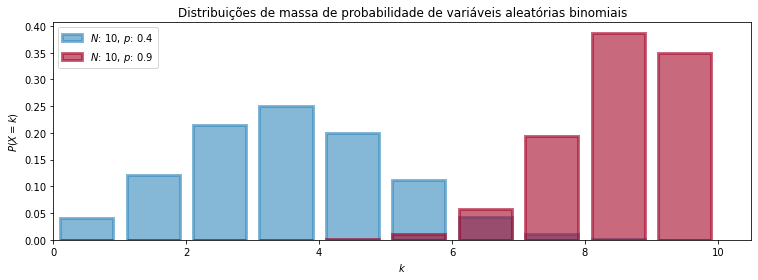

In [30]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ["#348ABD", "#A60628"]

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
            edgecolor=colors[i],
            alpha=0.6,
            label="$N$: %d, $p$: %.1f" % (N, p),
            linewidth=3)

plt.legend(loc="upper left")
plt.xlim(0, 10.5)
plt.xlabel("$k$")
plt.ylabel("$P(X = k)$")
plt.title("Distribuições de massa de probabilidade de variáveis aleatórias binomiais");

O caso especial em que $N = 1$ corresponde à distribuição de Bernoulli. Há outra conexão entre Bernoulli e variáveis aleatórias binomiais. Se tivermos $ X_1, X_2, ..., X_N $ variáveis aleatórias de Bernoulli com o mesmo $ p $, então $Z = X_1 + X_2 + ... + X_N \sim \text{Binomial} (N, p)$ .

O valor esperado de uma variável aleatória de Bernoulli é $p$. Isso pode ser visto observando que a variável aleatória Binomial mais geral tem valor esperado $Np$ e definindo $N = 1$.

##### Exemplo: Trapaça entre alunos
Usaremos a distribuição binomial para determinar a frequência com que os alunos colam durante um exame. Se consideramos $N$ como sendo o número total de alunos que fizeram o exame, e presumindo que cada aluno seja entrevistado após o exame (respondendo sem consequências punitivas), receberemos $X$ inteiros como respostas "Sim, eu colei!". Em seguida, encontramos a distribuição à posteriori de $p$, dados $N$, alguma priori sobre $p$, e dados observados $X$.

Este é um modelo completamente absurdo. Nenhum aluno, mesmo com um passe livre contra a punição, admitiria ter colado na prova. O que precisamos é de um *algoritmo* melhor para perguntar aos alunos se eles trapacearam. Idealmente, o algoritmo deve encorajar os indivíduos a serem honestos enquanto preserva a privacidade. O seguinte algoritmo proposto é uma solução que admiro muito por sua engenhosidade e eficácia:

> No processo de entrevista de cada aluno, o aluno joga uma moeda, escondida do entrevistador. O aluno concorda em responder honestamente se a moeda der cara. Caso contrário, se a moeda sair coroa, o aluno (secretamente) joga a moeda novamente e responde "Sim, eu trapaceei" se o lançamento da moeda cair cara e "Não, eu não colei", se o lançamento da moeda cair coroa. Dessa forma, o entrevistador não sabe se um "Sim" foi o resultado de uma confissão de culpa ou uma Cara em um segundo lançamento de moeda. Assim, a privacidade é preservada e os pesquisadores recebem respostas honestas.

Eu chamo isso de Algoritmo de Privacidade. É claro que alguém poderia argumentar que os entrevistadores ainda estão recebendo dados falsos, já que alguns *Sim* não são confissões, mas sim fator da aleatoriedade da moeda, mas uma perspectiva alternativa é que os pesquisadores estão descartando aproximadamente metade de seu conjunto de dados original, já que metade das respostas será ruído. Mas eles ganharam um processo sistemático de geração de dados que pode ser modelado. Além disso, eles não precisam incorporar (talvez um tanto ingenuamente) a possibilidade de respostas enganosas. Podemos usar PyMC3 para cavar através deste modelo ruidoso e encontrar uma distribuição á posteriori para a verdadeira frequência de mentirosos.

Suponha que 100 alunos estejam sendo pesquisados por trapacear e desejamos encontrar $p$, a proporção de trapaceiros. Existem algumas maneiras de modelar isso no PyMC3. Vou demonstrar a forma mais explícita e depois mostrar uma versão simplificada. Ambas as versões chegam à mesma inferência. Em nosso modelo de geração de dados, amostramos $p$, a verdadeira proporção de trapaceiros, de uma priori. Como não sabemos nada sobre $p$, iremos atribuir a ele um $\text{Uniforme}(0,1)$ à priori.

In [31]:
import pymc3 as pm

N = 100
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)

Mais uma vez, pensando em nosso modelo de geração de dados, atribuímos variáveis aleatórias Bernoulli aos $100$ alunos: 
 - $1$ indica que eles colaram e 
 - $0$ significa que não.

In [32]:
with model:
    true_answers = pm.Bernoulli("truths", p, shape=N, testval=np.random.binomial(1, 0.5, N))

Se rodarmos o algoritmo, o próximo passo será, primeiro, lançamento da moeda de cada aluno. Isso pode ser modelado novamente pela amostragem de 100 variáveis aleatórias de Bernoulli com $ p = 1/2 $: denote 1 como *Cara* e 0 como *Coroa*.

In [33]:
with model:
    first_coin_flips = pm.Bernoulli("first_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))
print(first_coin_flips.tag.test_value)

[0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1
 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0
 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0]


Embora *nem todos* joguem uma segunda vez, ainda podemos modelar a possível realização de segundos lançamentos de moeda:

In [34]:
with model:
    second_coin_flips = pm.Bernoulli("second_flips", 0.5, shape=N, testval=np.random.binomial(1, 0.5, N))

Usando essas variáveis, podemos retornar uma possível realização da *proporção observada* de respostas "Sim". Fazemos isso usando uma variável PyMC3 `deterministic`:

In [35]:
import theano.tensor as tt
with model:
    val = first_coin_flips*true_answers + (1 - first_coin_flips)*second_coin_flips
    observed_proportion = pm.Deterministic("observed_proportion", tt.sum(val)/float(N))

A linha `fc*t_a + (1-fc)*sc` contém o coração do algoritmo de privacidade. Os elementos neste array são $1$ *se e somente se*:
- i) o primeiro lance for cara e o aluno tiver colado ou 
- ii) o primeiro lance for coroa e o segundo for cara

e são $0$ caso contrário. 

Finalmente, a última linha soma este vetor e divide por `float(N)`, produzindo assim uma proporção.

In [36]:
observed_proportion.tag.test_value

array(0.52999997)

Em seguida, precisamos de um conjunto de dados. Depois de realizar nossas entrevistas trocadas, os pesquisadores receberam 35 respostas "Sim". Para colocar isso em uma perspectiva relativa, se realmente não houvesse trapaceiros, devemos esperar ver em média 1/4 de todas as respostas sendo um "Sim" ($0.5$ chance de ter a primeira moeda coroa, e $0.5$ chance de ter a segunda cara), então cerca de 25 respostas em um mundo sem trapaça. Por outro lado, se *todos os alunos trapacearem*, devemos esperar que aproximadamente 3/4 de todas as respostas sejam "Sim".

Os pesquisadores observam uma variável aleatória Binomial, com `N = 100` e `p=observed_proportion` com `valor=35`:

In [37]:
X = 35

with model:
    observations = pm.Binomial("obs", N, observed_proportion, observed=X)

Abaixo, adicionamos todas as variáveis de interesse a um `Model` e executamos nosso algoritmo (black-box) sobre o modelo.

In [38]:
# To be explained in Chapter 3!
with model:
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
Sampling 4 chains, 0 divergences: 100%|██████████| 162000/162000 [16:15<00:00, 166.04draws/s]
The number of effective samples is smaller than 10% for some parameters.


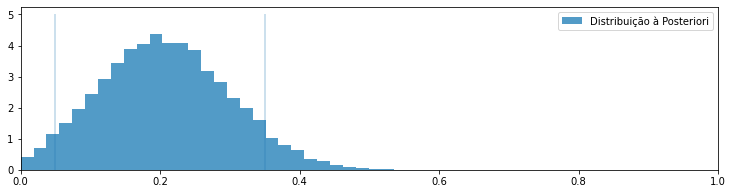

In [48]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"][15000:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="Distribuição à Posteriori", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

Com relação ao gráfico acima, ainda não temos certeza sobre qual pode ser a verdadeira frequência dos trapaceiros, mas reduzimos para um intervalo entre $0.05$ a $0.35$ (marcado pelas linhas contínuas). Isso é muito bom, pois *à priori* não tínhamos ideia de quantos alunos poderiam ter trapaceado (daí a distribuição uniforme da nossa priori). Por outro lado, também é muito ruim, já que há uma janela de comprimento de $0.3$ em que o valor verdadeiro provavelmente reside. Já ganhamos alguma coisa ou ainda estamos muito incertos sobre a verdadeira frequência?

Eu diria que sim, descobrimos algo. É inadmissível, de acordo com nossa posteriori, que não haja *nenhum trapaceiro*, ou seja, a posteriori atribui baixa probabilidade a $p = 0$. Como começamos com um priori uniforme, tratando todos os valores de $p$ como igualmente plausíveis, mas os dados descartaram $p=0$ como uma possibilidade, podemos ter certeza de que houve trapaceiros.

Esse tipo de algoritmo pode ser usado para coletar informações privadas dos usuários e ter a confiança *razoável* de que os dados, embora ruidosos, são verdadeiros.

### Modelo PyMC3 alternativo

Dado um valor para $p$ (que conhecemos pela nossa *posiçaõ divina*), podemos encontrar a probabilidade de o aluno responder sim:

\begin{align}
P(\text{"Yes"}) = & P( \text{Caras no primeiro lançamento} )P( \text{colou} ) + P( \text{Coroa na primeiro lançamento} )P( \text{Cara no segundo lançamento} ) \\\\
& = \frac{1}{2}p + \frac{1}{2} \times \frac{1}{2}\\\\
& = \frac{p}{2} + \frac{1}{4}
\end{align}

Assim, sabendo o $p$, sabemos a probabilidade de um aluno responder "Sim". Em PyMC3, podemos criar uma função determinística para avaliar a probabilidade de responder "Sim", dado $p$:

In [44]:
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)

Eu poderia ter digitado `p_skewed  = 0.5*p + 0.25` $^1$ em vez de uma linha, já que as operações elementares de adição e multiplicação escalar criarão implicitamente uma variável` deterministic`, mas eu queria tornar o boilerplate $^2$ determinístico explícito para fins de clareza.

Se sabemos a probabilidade dos respondentes dizerem "Sim", que é `p_skewed`, e temos $N=100$ alunos, o número de respostas "Sim" é uma variável aleatória binomial com parâmetros `N` e `p_skewed`.

É aqui que incluímos as nossas 35 respostas "sim" observadas. Na declaração do `pm.Binomial`, incluímos `value = 35` e `observed = True`.

----

$^1$ **Nota do Tradutor**: `p_skewed` pode ser entendido como um p viesado, ou seja, um p que tem um vício. 

$^2$ **Nota do Tradutor**: *Boilerplate*: Em programação, o *boilerplate code* ou apenas *boilerplate* se refere a seções de código que devem ser incluídas em muitos lugares com pouca ou nenhuma alteração. [Wikipédia](https://pt.wikipedia.org/wiki/Boilerplate_code)

In [45]:
with model:
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=35)

Abaixo, adicionamos todas as variáveis de interesse a um container chamado `Model` e executamos nosso algoritmo de black-box sobre o modelo.

In [46]:
with model:
    # Será explicado no capítulo 3!
    step = pm.Metropolis()
    trace = pm.sample(25000, step=step)
    burned_trace = trace[2500:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [freq_cheating]
Sampling 4 chains, 0 divergences: 100%|██████████| 102000/102000 [00:07<00:00, 13418.90draws/s]
The number of effective samples is smaller than 25% for some parameters.


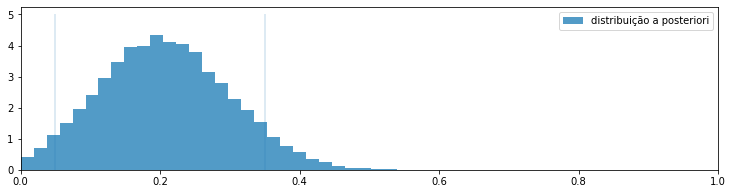

In [47]:
figsize(12.5, 3)
p_trace = burned_trace["freq_cheating"]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, bins=30, 
         label="distribuição à posteriori", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

### Mais truques do PyMC3

#### Dicas Profissionais: Arrays de variáveis PyMC3
Não há razão para que não possamos armazenar várias variáveis heterogêneas no PyMC3 em uma matriz Numpy. Apenas lembre-se de definir o `dtype` do array para `object` na inicialização. 

Por exemplo:

In [49]:
N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential('x_%i' % i, (i+1.0)**2)

O restante deste capítulo examina alguns exemplos práticos do PyMC3 de modelagem em PyMC3:


##### Example: Challenger Space Shuttle Disaster <span id="challenger"/>

On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend. The data are shown below (see [1]):





In [ ]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

#plot it, as a function of tempature (the first column)
print("Temp (F), O-Ring failure?")
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");


It looks clear that *the probability* of damage incidents occurring increases as the outside temperature decreases. We are interested in modeling the probability here because it does not look like there is a strict cutoff point between temperature and a damage incident occurring. The best we can do is ask "At temperature $t$, what is the probability of a damage incident?". The goal of this example is to answer that question.

We need a function of temperature, call it $p(t)$, that is bounded between 0 and 1 (so as to model a probability) and changes from 1 to 0 as we increase temperature. There are actually many such functions, but the most popular choice is the *logistic function.*

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t } } $$

In this model, $\beta$ is the variable we are uncertain about. Below is the function plotted for $\beta = 1, 3, -5$.

In [ ]:
figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.legend();

But something is missing. In the plot of the logistic function, the probability changes only near zero, but in our data above the probability changes around 65 to 70. We need to add a *bias* term to our logistic function:

$$p(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$

Some plots are below, with differing $\alpha$.

In [ ]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");

Adding a constant term $\alpha$ amounts to shifting the curve left or right (hence why it is called a *bias*).

Let's start modeling this in PyMC3. The $\beta, \alpha$ parameters have no reason to be positive, bounded or relatively large, so they are best modeled by a *Normal random variable*, introduced next.

### Normal distributions

A Normal random variable, denoted $X \sim N(\mu, 1/\tau)$, has a distribution with two parameters: the mean, $\mu$, and the *precision*, $\tau$. Those familiar with the Normal distribution already have probably seen $\sigma^2$ instead of $\tau^{-1}$. They are in fact reciprocals of each other. The change was motivated by simpler mathematical analysis and is an artifact of older Bayesian methods. Just remember: the smaller $\tau$, the larger the spread of the distribution (i.e. we are more uncertain); the larger $\tau$, the tighter the distribution (i.e. we are more certain). Regardless, $\tau$ is always positive. 

The probability density function of a $N( \mu, 1/\tau)$ random variable is:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x-\mu)^2 \right) $$

We plot some different density functions below. 

In [ ]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ["#348ABD", "#A60628", "#7A68A6"]
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./_tau),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1./_tau), color=_color,
                     alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Probability distribution of three different Normal random \
variables");

A Normal random variable can be take on any real number, but the variable is very likely to be relatively close to $\mu$. In fact, the expected value of a Normal is equal to its $\mu$ parameter:

$$ E[ X | \mu, \tau] = \mu$$

and its variance is equal to the inverse of $\tau$:

$$Var( X | \mu, \tau ) = \frac{1}{\tau}$$



Below we continue our modeling of the Challenger space craft:

In [ ]:
import pymc3 as pm

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))

We have our probabilities, but how do we connect them to our observed data? A *Bernoulli* random variable with parameter $p$, denoted $\text{Ber}(p)$, is a random variable that takes value 1 with probability $p$, and 0 else. Thus, our model can look like:

$$ \text{Defect Incident, $D_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

where $p(t)$ is our logistic function and $t_i$ are the temperatures we have observations about. Notice in the above code we had to set the values of `beta` and `alpha` to 0. The reason for this is that if `beta` and `alpha` are very large, they make `p` equal to 1 or 0. Unfortunately, `pm.Bernoulli` does not like probabilities of exactly 0 or 1, though they are mathematically well-defined probabilities. So by setting the coefficient values to `0`, we set the variable `p` to be a reasonable starting value. This has no effect on our results, nor does it mean we are including any additional information in our prior. It is simply a computational caveat in PyMC3. 

In [ ]:
# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    # Mysterious code to be explained in Chapter 3
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

We have trained our model on the observed data, now we can sample values from the posterior. Let's look at the posterior distributions for $\alpha$ and $\beta$:

In [ ]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

All samples of $\beta$ are greater than 0. If instead the posterior was centered around 0, we may suspect that $\beta = 0$, implying that temperature has no effect on the probability of defect. 

Similarly, all $\alpha$ posterior values are negative and far away from 0, implying that it is correct to believe that $\alpha$ is significantly less than 0. 

Regarding the spread of the data, we are very uncertain about what the true parameters might be (though considering the low sample size and the large overlap of defects-to-nondefects this behaviour is perhaps expected).  

Next, let's look at the *expected probability* for a specific value of the temperature. That is, we average over all samples from the posterior to get a likely value for $p(t_i)$.

In [ ]:
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

In [ ]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

Above we also plotted two possible realizations of what the actual underlying system might be. Both are equally likely as any other draw. The blue line is what occurs when we average all the 20000 possible dotted lines together.


An interesting question to ask is for what temperatures are we most uncertain about the defect-probability? Below we plot the expected value line **and** the associated 95% intervals for each temperature. 

In [ ]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

The *95% credible interval*, or 95% CI, painted in purple, represents the interval, for each temperature, that contains 95% of the distribution. For example, at 65 degrees, we can be 95% sure that the probability of defect lies between 0.25 and 0.75.

More generally, we can see that as the temperature nears 60 degrees, the CI's spread out over [0,1] quickly. As we pass 70 degrees, the CI's tighten again. This can give us insight about how to proceed next: we should probably test more O-rings around 60-65 temperature to get a better estimate of probabilities in that range. Similarly, when reporting to scientists your estimates, you should be very cautious about simply telling them the expected probability, as we can see this does not reflect how *wide* the posterior distribution is.

### What about the day of the Challenger disaster?

On the day of the Challenger disaster, the outside temperature was 31 degrees Fahrenheit. What is the posterior distribution of a defect occurring,  given this temperature? The distribution is plotted below. It looks almost guaranteed that the Challenger was going to be subject to defective O-rings.

In [ ]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

### Is our model appropriate?

The skeptical reader will say "You deliberately chose the logistic function for $p(t)$ and the specific priors. Perhaps other functions or priors will give different results. How do I know I have chosen a good model?" This is absolutely true. To consider an extreme situation, what if I had chosen the function $p(t) = 1,\; \forall t$, which guarantees a defect always occurring: I would have again predicted disaster on January 28th. Yet this is clearly a poorly chosen model. On the other hand, if I did choose the logistic function for $p(t)$, but specified all my priors to be very tight around 0, likely we would have very different posterior distributions. How do we know our model is an expression of the data? This encourages us to measure the model's **goodness of fit**.

We can think: *how can we test whether our model is a bad fit?* An idea is to compare observed data (which if we recall is a *fixed* stochastic variable) with artificial dataset which we can simulate. The rationale is that if the simulated dataset does not appear similar, statistically, to the observed dataset, then likely our model is not accurately represented the observed data. 

Previously in this Chapter, we simulated artificial dataset for the SMS example. To do this, we sampled values from the priors. We saw how varied the resulting datasets looked like, and rarely did they mimic our observed dataset. In the current example,  we should sample from the *posterior* distributions to create *very plausible datasets*. Luckily, our Bayesian framework makes this very easy. We only need to create a new `Stochastic` variable, that is exactly the same as our variable that stored the observations, but minus the observations themselves. If you recall, our `Stochastic` variable that stored our observed data was:

    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)

Hence we create:
    
    simulated_data = pm.Bernoulli("simulation_data", p)

Let's simulate 10 000:

In [ ]:
N = 10000
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0)
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    simulated = pm.Bernoulli("bernoulli_sim", p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step=step)

In [ ]:
figsize(12.5, 5)

simulations = trace["bernoulli_sim"]
print(simulations.shape)

plt.title("Simulated dataset using posterior parameters")
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(temperature, simulations[1000*i, :], color="k",
                s=50, alpha=0.6)

Note that the above plots are different (if you can think of a cleaner way to present this, please send a pull request and answer [here](http://stats.stackexchange.com/questions/53078/how-to-visualize-bayesian-goodness-of-fit-for-logistic-regression)!).

We wish to assess how good our model is. "Good" is a subjective term of course, so results must be relative to other models. 

We will be doing this graphically as well, which may seem like an even less objective method. The alternative is to use *Bayesian p-values*. These are still subjective, as the proper cutoff between good and bad is arbitrary. Gelman emphasises that the graphical tests are more illuminating [7] than p-value tests. We agree.

The following graphical test is a novel data-viz approach to logistic regression. The plots are called *separation plots*[8]. For a suite of models we wish to compare, each model is plotted on an individual separation plot. I leave most of the technical details about separation plots to the very accessible [original paper](http://mdwardlab.com/sites/default/files/GreenhillWardSacks.pdf), but I'll summarize their use here.

For each model, we calculate the proportion of times the posterior simulation proposed a value of 1 for a particular temperature, i.e. compute $P( \;\text{Defect} = 1 | t, \alpha, \beta )$ by averaging. This gives us the posterior probability of a defect at each data point in our dataset. For example, for the model we used above:

In [ ]:
posterior_probability = simulations.mean(axis=0)
print("posterior prob of defect | realized defect ")
for i in range(len(D)):
    print("%.2f                     |   %d" % (posterior_probability[i], D[i]))

Next we sort each column by the posterior probabilities:

In [ ]:
ix = np.argsort(posterior_probability)
print("probb | defect ")
for i in range(len(D)):
    print("%.2f  |   %d" % (posterior_probability[ix[i]], D[ix[i]]))

We can present the above data better in a figure: I've wrapped this up into a `separation_plot` function.

In [ ]:
from separation_plot import separation_plot


figsize(11., 1.5)
separation_plot(posterior_probability, D)

The snaking-line is the sorted probabilities, blue bars denote defects, and empty space (or grey bars for the optimistic readers) denote non-defects.  As the probability rises, we see more and more defects occur. On the right hand side, the plot suggests that as the posterior probability is large (line close to 1), then more defects are realized. This is good behaviour. Ideally, all the blue bars *should* be close to the right-hand side, and deviations from this reflect missed predictions. 

The black vertical line is the expected number of defects we should observe, given this model. This allows the user to see how the total number of events predicted by the model compares to the actual number of events in the data.

It is much more informative to compare this to separation plots for other models. Below we compare our model (top) versus three others:

1. the perfect model, which predicts the posterior probability to be equal 1 if a defect did occur.
2. a completely random model, which predicts random probabilities regardless of temperature.
3. a constant model:  where $P(D = 1 \; | \; t) = c, \;\; \forall t$. The best choice for $c$ is the observed frequency of defects, in this case 7/23.  


In [ ]:
figsize(11., 1.25)

# Our temperature-dependent model
separation_plot(posterior_probability, D)
plt.title("Temperature-dependent model")

# Perfect model
# i.e. the probability of defect is equal to if a defect occurred or not.
p = D
separation_plot(p, D)
plt.title("Perfect model")

# random predictions
p = np.random.rand(23)
separation_plot(p, D)
plt.title("Random model")

# constant model
constant_prob = 7./23*np.ones(23)
separation_plot(constant_prob, D)
plt.title("Constant-prediction model");

In the random model, we can see that as the probability increases there is no clustering of defects to the right-hand side. Similarly for the constant model.

The perfect model, the probability line is not well shown, as it is stuck to the bottom and top of the figure. Of course the perfect model is only for demonstration, and we cannot infer any scientific inference from it.

##### Exercises

1\. Try putting in extreme values for our observations in the cheating example. What happens if we observe 25 affirmative responses? 10? 50? 

2\. Try plotting $\alpha$ samples versus $\beta$ samples.  Why might the resulting plot look like this?

In [ ]:
#type your code here.
figsize(12.5, 4)

plt.scatter(alpha_samples, beta_samples, alpha=0.1)
plt.title("Why does the plot look like this?")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$");

### References

-  [1] Dalal, Fowlkes and Hoadley (1989),JASA, 84, 945-957.
-  [2] German Rodriguez. Datasets. In WWS509. Retrieved 30/01/2013, from <http://data.princeton.edu/wws509/datasets/#smoking>.
-  [3] McLeish, Don, and Cyntha Struthers. STATISTICS 450/850 Estimation and Hypothesis Testing. Winter 2012. Waterloo, Ontario: 2012. Print.
-  [4] Fonnesbeck, Christopher. "Building Models." PyMC-Devs. N.p., n.d. Web. 26 Feb 2013. <http://pymc-devs.github.com/pymc/modelbuilding.html>.
- [5] Cronin, Beau. "Why Probabilistic Programming Matters." 24 Mar 2013. Google, Online Posting to Google . Web. 24 Mar. 2013. <https://plus.google.com/u/0/107971134877020469960/posts/KpeRdJKR6Z1>.
- [6] S.P. Brooks, E.A. Catchpole, and B.J.T. Morgan. Bayesian animal survival estimation. Statistical Science, 15: 357–376, 2000
- [7] Gelman, Andrew. "Philosophy and the practice of Bayesian statistics." British Journal of Mathematical and Statistical Psychology. (2012): n. page. Web. 2 Apr. 2013.
- [8] Greenhill, Brian, Michael D. Ward, and Audrey Sacks. "The Separation Plot: A New Visual Method for Evaluating the Fit of Binary Models." American Journal of Political Science. 55.No.4 (2011): n. page. Web. 2 Apr. 2013.

In [ ]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()